<a href="https://colab.research.google.com/github/claredavies/MachineLearningCoursework/blob/main/Assignment1/MLAssignment1KerrasUnbalancedData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Libraries & read in file

In [22]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow.keras import preprocessing
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [23]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('bank-additional-full.csv', sep=';', delimiter=None, header='infer', names=None, index_col=None)

Saving bank-additional-full.csv to bank-additional-full (2).csv


# Data Exploration

(41188, 21)
No claim 36548
Claim 4640
Claim proportion 11.27%


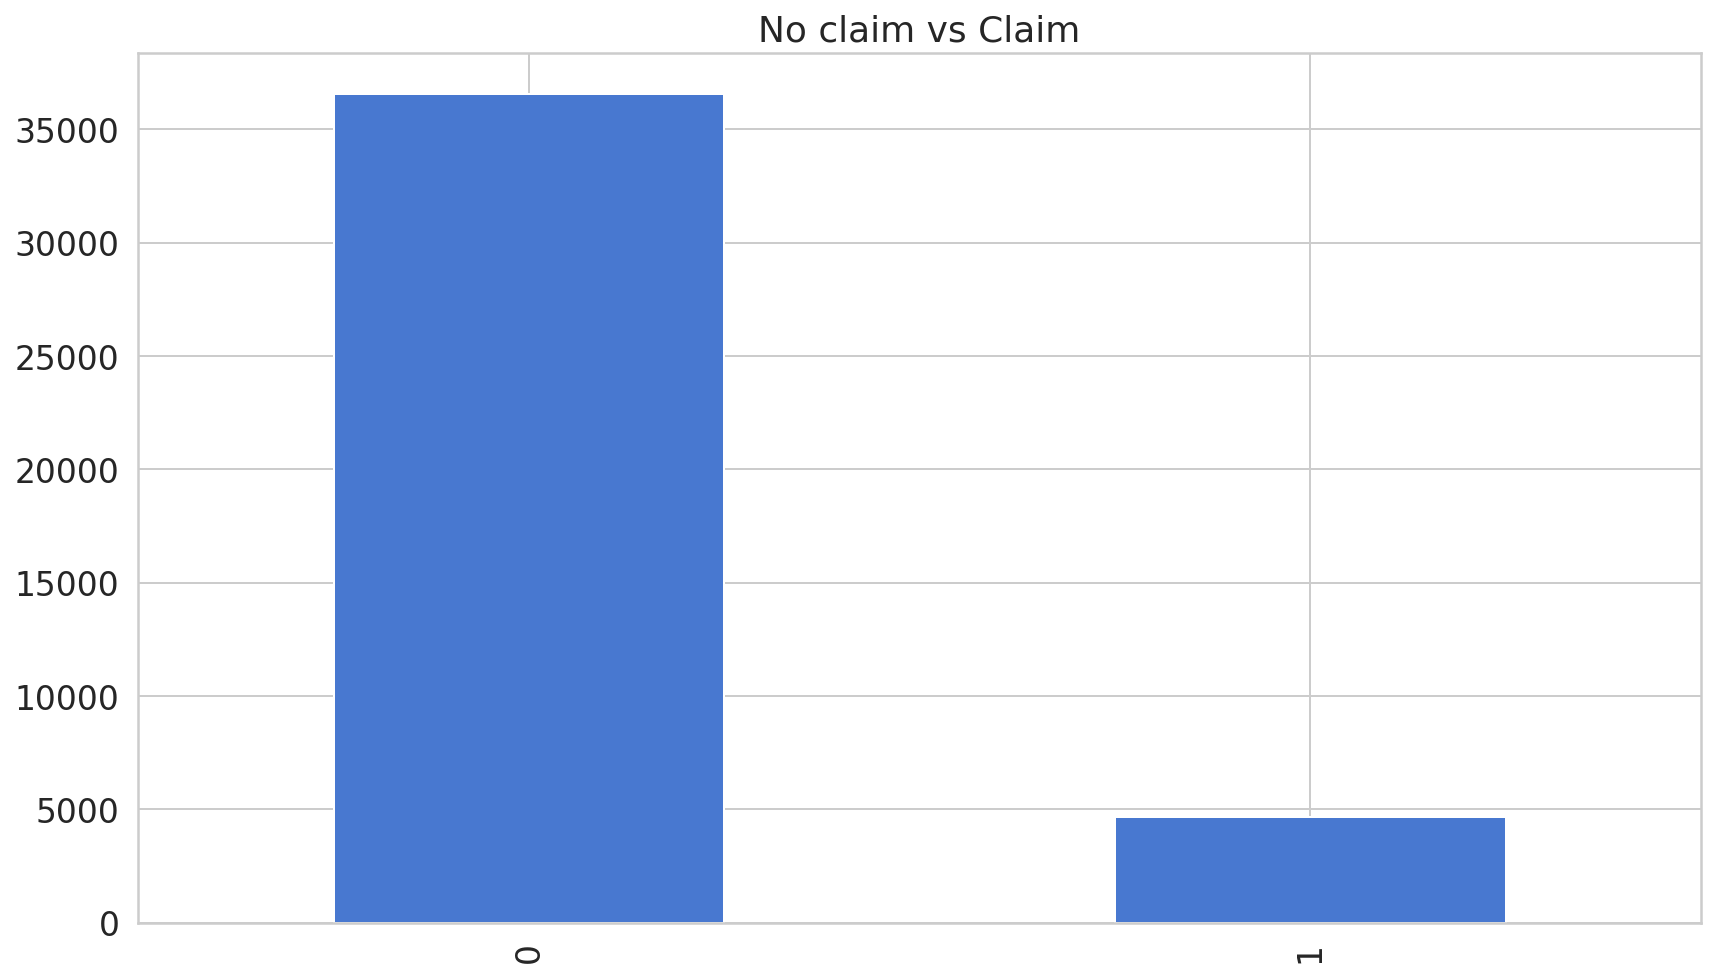

In [24]:
print(df.shape)
df.columns

def percentage(part, whole):
  return 100 * float(part) / float(whole)

df.rename(columns = {'y':'target'}, inplace = True)
df['target'] = df.target.apply(lambda x: 1 if x == "yes" else 0)

no_claim, claim = df.target.value_counts()
print(f'No claim {no_claim}')
print(f'Claim {claim}')
print(f'Claim proportion {round(percentage(claim, claim + no_claim), 2)}%')

df.target.value_counts().plot(kind="bar", title="No claim vs Claim");

## Data preprocessing

In [25]:
row_count = df.shape[0]

for c in df.columns:
  m_count = df[df[c] == -1][c].count()
  if m_count > 0:    
    print(f'{c} - {m_count} ({round(percentage(m_count, row_count), 3)}%) rows missing')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

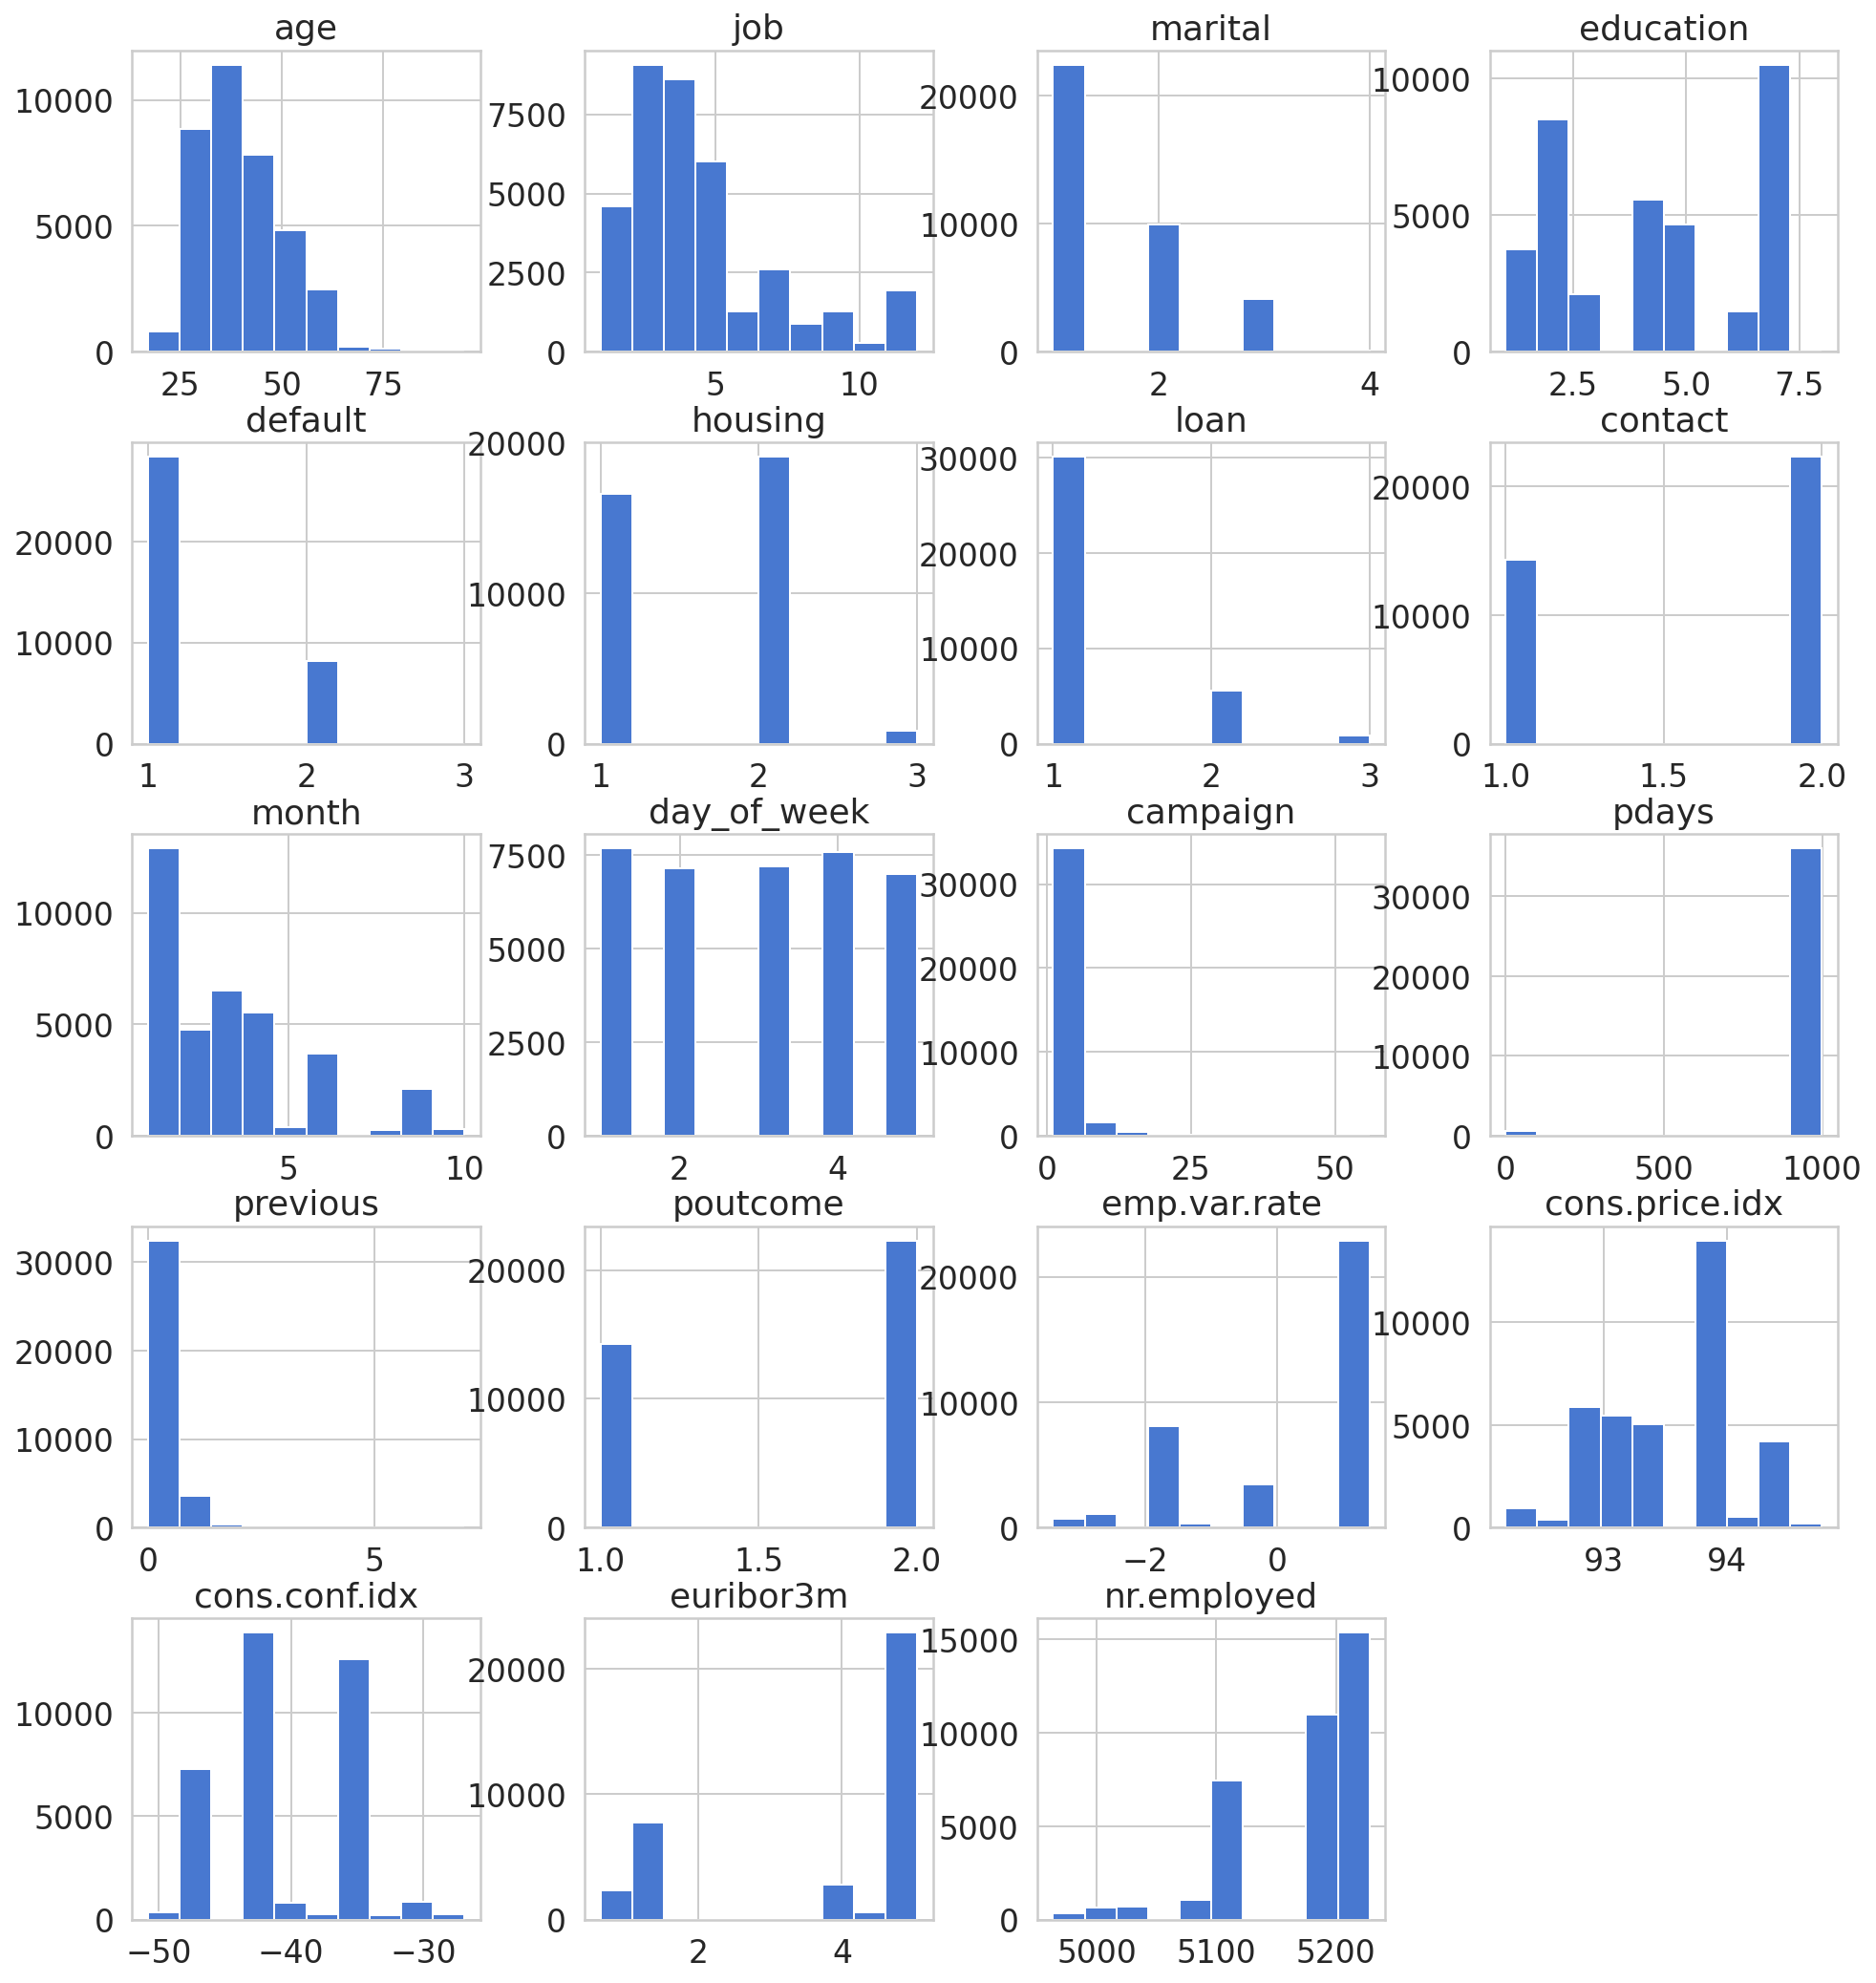

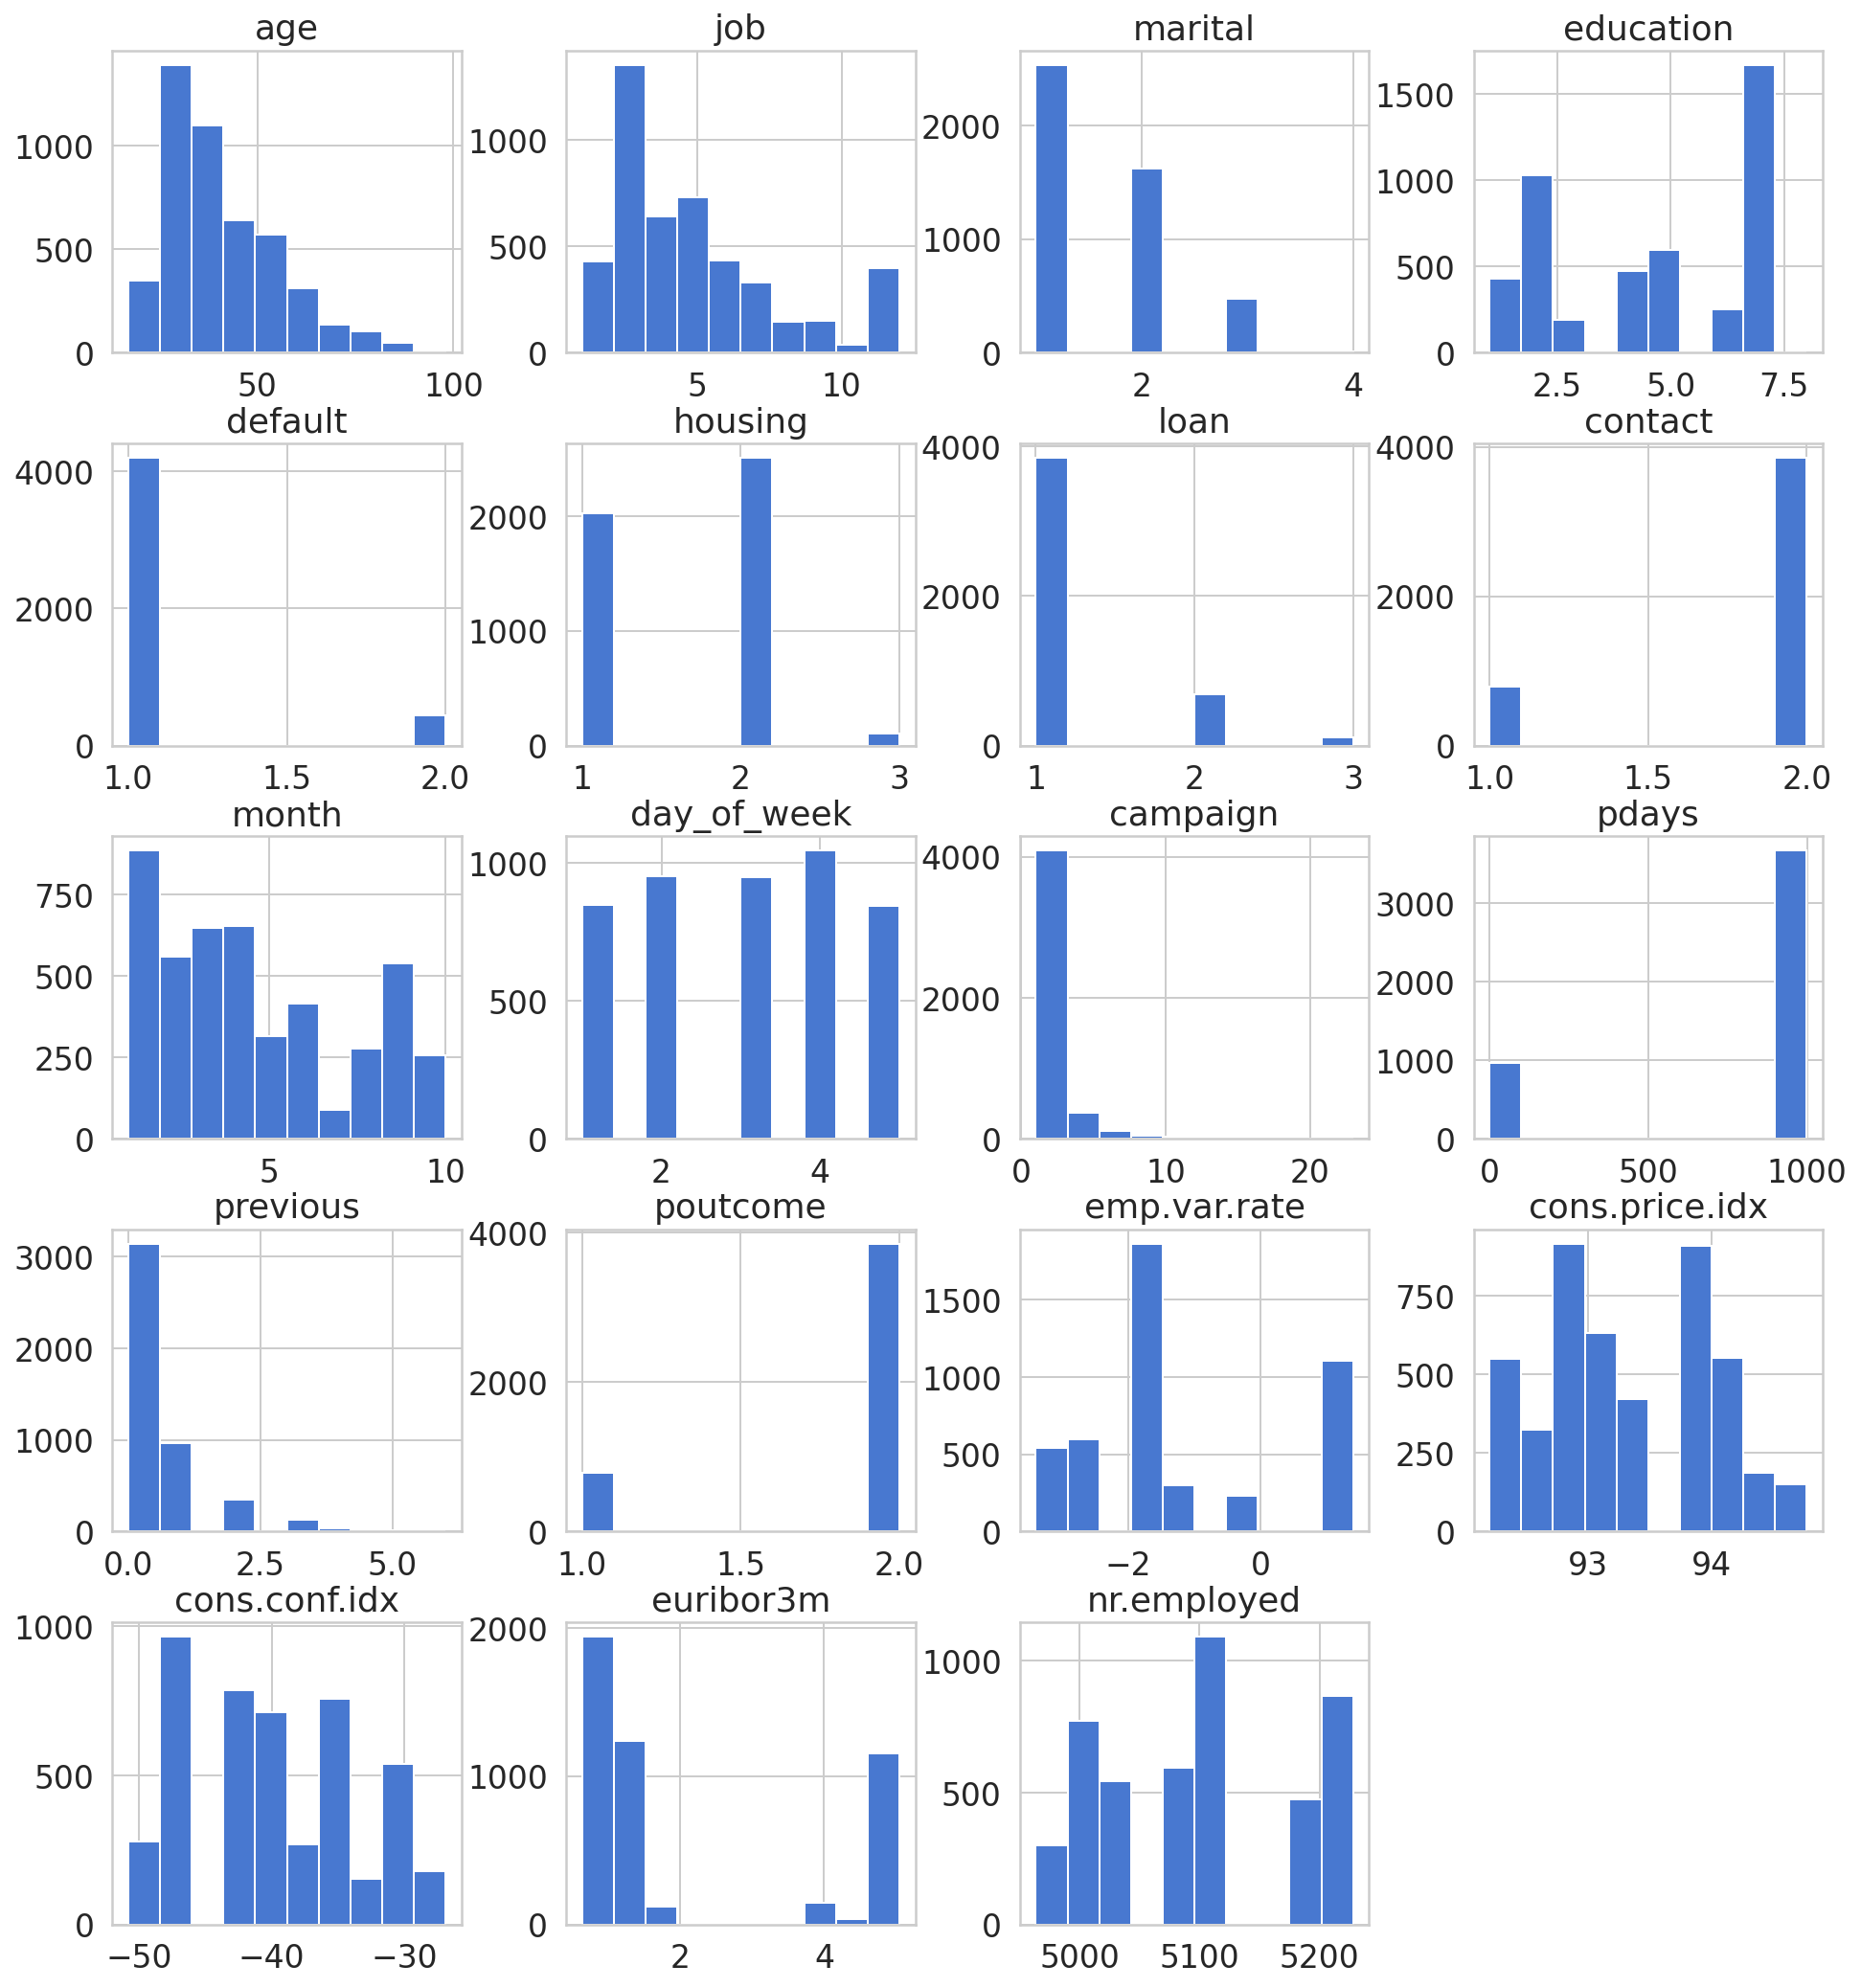

In [26]:
df.info()

df['job'] = pd.factorize(df['job'])[0] + 1
df['marital'] = pd.factorize(df['marital'])[0] + 1
df['education'] = pd.factorize(df['education'])[0] + 1
df['default'] = pd.factorize(df['default'])[0] + 1
df['housing'] = pd.factorize(df['housing'])[0] + 1
df['default'] = pd.factorize(df['default'])[0] + 1
df['loan'] = pd.factorize(df['loan'])[0] + 1
df['contact'] = pd.factorize(df['contact'])[0] + 1
df['month'] = pd.factorize(df['month'])[0] + 1
df['day_of_week'] = pd.factorize(df['day_of_week'])[0] + 1
df['poutcome'] = pd.factorize(df['contact'])[0] + 1

# Should remove - duration as only for benchmark
df = df.drop('duration', 1)

df.groupby('target').hist(figsize = (16,18))
df['previously_contacted'] = df.pdays.apply(lambda x: 0 if x == 999 else 1)
df = df.drop('pdays', 1)

## Neural Network

In [27]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [28]:
BATCH_SIZE = 2048

def build_model(train_data, metrics=METRICS):
  model = keras.Sequential([
    keras.layers.Dense(
      units=36, 
      activation='relu',
      input_shape=(train_data.shape[-1],)
    ),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(units=1, activation='sigmoid'),
  ])

  model.compile(
    optimizer=keras.optimizers.Adam(lr=0.001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=metrics
  )

  return model

# Metrics

In [29]:
from sklearn.metrics import confusion_matrix

def plot_cm(labels, predictions, p=0.5):

  tick_labels = ['Y', 'N']

  cm = confusion_matrix(labels, predictions > p)
  ax = sns.heatmap(cm, annot=True, fmt="d")
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(tick_labels)
  ax.set_yticklabels(tick_labels)

  print('% right for no: ', cm[0][0]/(cm[0][0] + cm[0][1]))
  print('% right for yes: ', cm[1][1]/(cm[1][1] + cm[1][0]))

In [30]:
from sklearn.metrics import f1_score

def print_metrics(model, evaluation_results, predictions):
  for name, value in zip(model.metrics_names, evaluation_results):
    print(name, ': ', value)
  print(f'f1 score: {f1_score(y_test, np.round(y_pred.flatten()))}')
  print()

# Create Model

In [31]:
from sklearn.model_selection import train_test_split

X = df.drop("target",1)
y = df['target']

labels = X.columns.values

from sklearn.preprocessing import StandardScaler
standardizer = StandardScaler()
X = standardizer.fit_transform(X)

# Print mean and standard deviation
print("Mean:", round(X[:,0].mean()))
print("Standard deviation:", X[:,0].std())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=RANDOM_SEED)

Mean: 0
Standard deviation: 0.9999999999999998


# Weighted model

In [32]:
no_claim_count, claim_count = np.bincount(df.target)
total_count = len(df.target)

weight_no_claim = (1 / no_claim_count) * (total_count) / 2.0 
weight_claim = ((1 / claim_count) * (total_count) / 2.0 ) 
print("no claim:  " + str(weight_no_claim))
print("claim:  " + str(weight_claim))
class_weights = {0: weight_no_claim, 1: weight_claim}

no claim:  0.5634781656999015
claim:  4.438362068965517


In [33]:
model_weighted = build_model(X_train, metrics=METRICS)

history_weighted = model_weighted.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=40,
    validation_data=(X_test, y_test), 
    shuffle=True,
    class_weight=class_weights
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/40
20/20 [==============================] - 3s 59ms/step - loss: 0.7133 - tp: 2828.0000 - fp: 14210.0000 - tn: 20515.0000 - fn: 1575.0000 - accuracy: 0.5966 - precision: 0.1660 - recall: 0.6423 - auc: 0.6715 - val_loss: 0.9592 - val_tp: 218.0000 - val_fp: 1445.0000 - val_tn: 378.0000 - val_fn: 19.0000 - val_accuracy: 0.2893 - val_precision: 0.1311 - val_recall: 0.9198 - val_auc: 0.7516
Epoch 2/40
20/20 [==============================] - 0s 12ms/step - loss: 0.6514 - tp: 2978.0000 - fp: 11501.0000 - tn: 23224.0000 - fn: 1425.0000 - accuracy: 0.6696 - precision: 0.2057 - recall: 0.6764 - auc: 0.7298 - val_loss: 0.8323 - val_tp: 201.0000 - val_fp: 1084.0000 - val_tn: 739.0000 - val_fn: 36.0000 - val_accuracy: 0.4563 - val_precision: 0.1564 - val_recall: 0.8481 - val_auc: 0.7571
Epoch 3/40
20/20 [==============================] - 0s 11ms/step - loss: 0.6331 - tp: 2850.0000 - fp: 9945.0000 - tn: 24780.0000 - fn: 1553.0000 - accuracy: 0.7061 - precision: 0.2227 - recall: 0.6473 - auc

Evaluation

In [34]:
evaluation_results = model_weighted.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
y_pred = model_weighted.predict(X_test, batch_size=BATCH_SIZE)
print_metrics(model_weighted, evaluation_results, y_pred)

loss :  0.5269808173179626
tp :  149.0
fp :  309.0
tn :  1514.0
fn :  88.0
accuracy :  0.8072815537452698
precision :  0.3253275156021118
recall :  0.6286919713020325
auc :  0.786795973777771
f1 score: 0.4287769784172662



% right for no:  0.8304991771804717
% right for yes:  0.6286919831223629


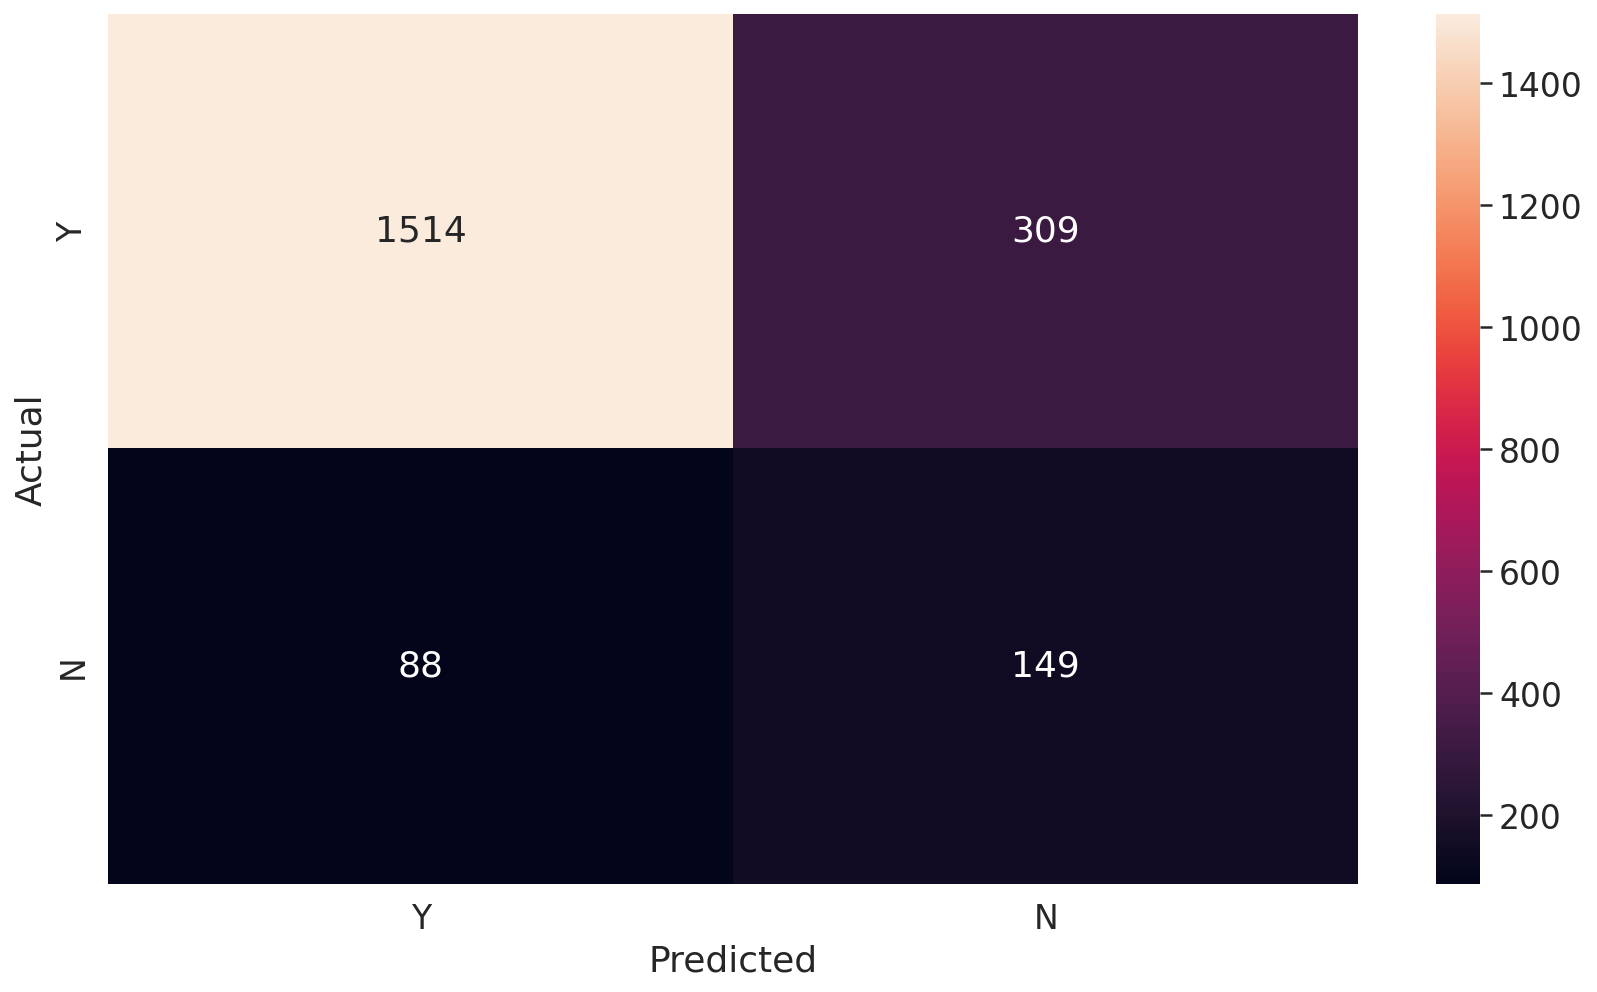

In [35]:
plot_cm(y_test, y_pred)

# Architecture

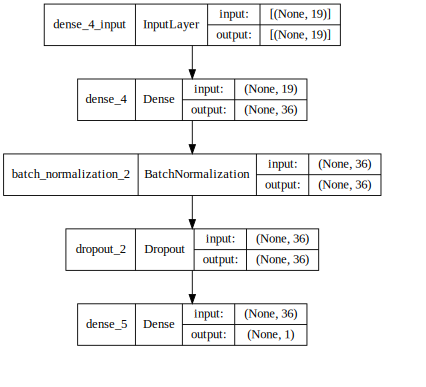

In [36]:
from IPython.display import SVG
import tensorflow as tf
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model_weighted, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))